# Setup

In [1]:
!pip3 install torchsummary

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PyTorch Data Importing
https://dev.to/mariazentsova/how-to-load-data-from-s3-to-aws-sagemaker-mea

In [4]:
import boto3
s3 = boto3.resource('s3')
bucket = s3.Bucket('cassava-images')

In [5]:
for item in bucket.objects.all():
    print(item)

s3.ObjectSummary(bucket_name='cassava-images', key='train.csv')
s3.ObjectSummary(bucket_name='cassava-images', key='train_images.zip')


In [6]:
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket = 'cassava-images', Key='train.csv')
images_df = pd.read_csv('s3://cassava-images/train.csv')

In [7]:
images_df.head(5)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [8]:
from io import BytesIO
from zipfile import ZipFile

obj = bucket.Object('train_images.zip')
bytes_ = BytesIO(obj.get()["Body"].read())
z = ZipFile(bytes_)

In [9]:
file = z.open('100042118.jpg')
data = Image.open(file)

In [10]:
ENCODING_TO_LABEL = {
    0: "Bacterial Blight (CBB)",
    1: "Brown Streak Disease (CBSD)",
    2: "Green Mottle (CGM)",
    3: "Mosaic Disease (CMD)",
    4: "Healthy"
}
LABEL_TO_ENCODING = {
    "Bacterial Blight (CBB)": 0,
    "Brown Streak Disease (CBSD)": 1,
    "Green Mottle (CGM)": 2,
    "Mosaic Disease (CMD)": 3,
    "Healthy": 4
}

# Data Loader Class

In [11]:
class CASDataset(Dataset):
    
    def __init__(self, z, labels, transform=None):
        """
        z:         ZipFile containing the images
        labels:    pandas dataframe [image_id, label]
        transform: Some function to apply transformations to the dataset
        """
        self.z = z
        self.labels = labels.reset_index()
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.labels['image_id'].at[idx]
        
        image = Image.open(z.open(img_name))
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels['label'].at[idx]
        
        return (image, label)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Resize((224, 224))
])

In [13]:
from sklearn.model_selection import train_test_split

# Generates a 0.6, 0.2, 0.2 Train, Val, Test split

train_df, test_df = train_test_split(images_df, test_size = 0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state=42)

# Subsamples the training set for faster hyperparameter space search (0.2 of total dataset)
train_df_sub, _ = train_test_split(train_df, test_size = 0.66, random_state=42)

In [14]:
train_df.head(10)

,image_id,label
13753,3459805310.jpg,3
18365,439346642.jpg,1
1263,1220597062.jpg,3
16020,3882757126.jpg,0
19951,72014881.jpg,4
13705,3453071010.jpg,4
13530,3418761424.jpg,3
10986,295733469.jpg,4
3939,1700592380.jpg,3
8357,2484373271.jpg,1


In [15]:
train_dataset = CASDataset(z, train_df, transform=transform)
val_dataset = CASDataset(z, val_df, transform=transform)
test_dataset = CASDataset(z, test_df, transform=transform)
train_dataset_sub = CASDataset(z, train_df_sub, transform=transform)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
train_dataloader_sub = DataLoader(train_dataset_sub, batch_size=64, shuffle=True)

## Visualisation of dataset

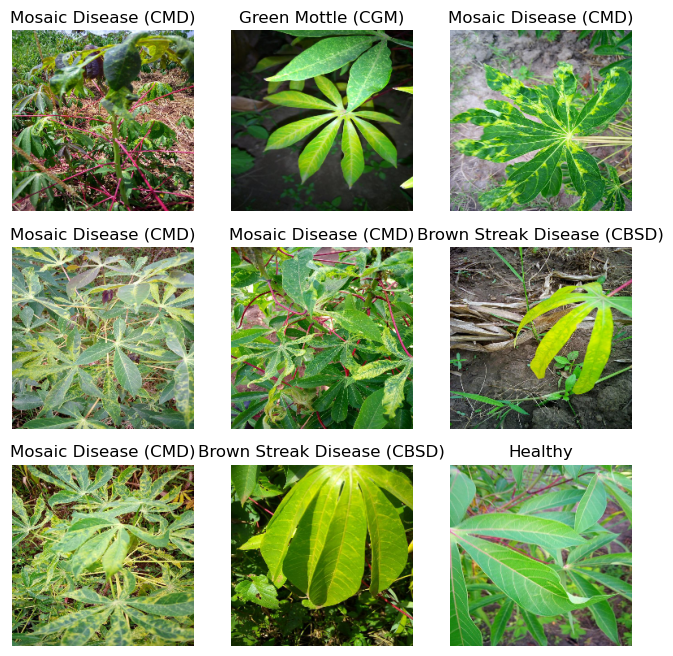

In [17]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
torch.manual_seed(42)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(ENCODING_TO_LABEL[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)
plt.show()

# ResNet Transfer Learning

In [18]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [19]:
def setup_model(fc="lin", freeze="none", version="50", opt="sgd", lr=0.01, step_size=100, pretrained=True):
    print(fc, freeze, version, opt, lr, pretrained)

    model = None

    # Init model
    if version == "50":
        if pretrained:
            model = models.resnet50(weights="IMAGENET1K_V2")
        else:
            model = models.resnet50(weights=None)
    elif version == "18":
        if pretrained:
            model = models.resnet18(weights="IMAGENET1K_V1")
        else:
            model = models.resnet18(weights=None)
    
    num_ftrs = model.fc.in_features

    # Freeze layers
    for (name, module) in model.named_children():
        for layer in module.children():
            for param in layer.parameters():
                if freeze != "none" and ((name != 'layer4' and freeze == "part") or freeze == "all"):
                    param.requires_grad=False

    # Set last layer
    if fc == "lin":
        model.fc = nn.Linear(num_ftrs, 5);
    elif fc == "seq":
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 5), 
        )

    model = model.to(device)
    
#     print(summary(model, (3, 244, 244)))

    criterion = nn.CrossEntropyLoss()

    optimizer = None
    if opt == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Dummy scheduler (can get replaced later)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
    
    return model, criterion, optimizer, scheduler

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, thresh=0.95, sub=False):
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    
    chosen_dataloader = train_dataloader_sub if sub else train_dataloader

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        
        for i, data in enumerate(chosen_dataloader, 0):

            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 2. Get the model predictions
            predictions = model(inputs)

            # 3. Zero the gradients out
            optimizer.zero_grad()

            # 4. Get the loss
            loss = criterion(predictions, labels)

            # 5. Calculate the gradients
            loss.backward()

            # 6. Update the weights
            optimizer.step()
                
            running_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
            
        train_loss.append(running_loss / len(chosen_dataloader))
        train_acc.append(correct/total)
                
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        
        for i, data in enumerate(val_dataloader, 0):

            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 2. Get the model predictions
            predictions = model(inputs)

            # 3. Get the loss
            loss = criterion(predictions, labels)

            running_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        validation_loss.append(running_loss / len(val_dataloader))
        validation_acc.append(correct/total)

        print(f"Epoch {epoch+1}:")

        print(f"Training Loss:", round(train_loss[epoch], 3))
        print(f"Validation Loss:", round(validation_loss[epoch], 3))
        
        print(f"Training Accuracy:", round(train_acc[epoch], 3))
        print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

        print("------------------------------")
        
        if train_acc[-1] > thresh:
            break
        
    return (train_acc[-1], validation_acc[-1])

In [21]:
def test_model(model, criterion):
    running_loss = 0.
    correct, total = 0, 0

    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data

        # 1. Store the inputs and labels in the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 2. Get the model predictions
        predictions = model(inputs)

        # 3. Get the loss
        loss = criterion(predictions, labels)

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Loss:", running_loss / len(test_dataloader))
    print(f"Test Accuracy:", correct/total)

In [21]:
# Vary last layer, freeze
results = []
for fc in ["lin", "seq"]:
    for freeze in ["none", "part", "all"]:
        model, criterion, optimizer, scheduler = setup_model(fc=fc, freeze=freeze)
        (train_acc, val_acc) = train_model(model, criterion, optimizer, scheduler, num_epochs=7, sub=True)
        results.append((fc, freeze, train_acc, val_acc))
        print(results[-1])
        print("******************************\n")

for result in results:
    print(result)

lin none 50 sgd 0.01 True
Epoch 1:
Training Loss: 0.315
Validation Loss: 0.693
Training Accuracy: 0.66
Validation Accuracy: 0.742
------------------------------
Epoch 2:
Training Loss: 0.178
Validation Loss: 0.567
Training Accuracy: 0.813
Validation Accuracy: 0.805
------------------------------
Epoch 3:
Training Loss: 0.091
Validation Loss: 0.592
Training Accuracy: 0.909
Validation Accuracy: 0.803
------------------------------
Epoch 4:
Training Loss: 0.045
Validation Loss: 0.691
Training Accuracy: 0.961
Validation Accuracy: 0.794
------------------------------
('lin', 'none', 0.9605866177818515, 0.7941588785046729)
******************************

lin part 50 sgd 0.01 True
Epoch 1:
Training Loss: 0.339
Validation Loss: 0.764
Training Accuracy: 0.643
Validation Accuracy: 0.701
------------------------------
Epoch 2:
Training Loss: 0.226
Validation Loss: 0.68
Training Accuracy: 0.752
Validation Accuracy: 0.754
------------------------------
Epoch 3:
Training Loss: 0.15
Validation Loss: 

It appears that the difference between lin and seq is relatively low across the board. We therefore choose linear in appreciation for Occam and his razor. It looks not freezing did the best, but overfit. Freezing layers had lower accuracy than freezing no layers with even greater overfitting. Freezing all layers had the lowest accuracy, but faced less overfitting. It is possible that this would actually be a better model if given enough time to train, since we kept number of epochs relatively low. 

Therefore, we decide on two candidate model architectures: single linear final layer, freezing either no or all layers. 

In [22]:
# Vary optimizer, freeze
results = []
for freeze in ["none", "all"]:
    for opt in ["sgd", "adam"]:
        model, criterion, optimizer, scheduler = setup_model(fc="lin", freeze=freeze, opt=opt)
        (train_acc, val_acc) = train_model(model, criterion, optimizer, scheduler, num_epochs=10, thresh=0.99, sub=True)
        results.append((freeze, opt, train_acc, val_acc))
        print(results[-1])
        print("******************************\n")

for result in results:
    print(result)

lin none 50 sgd 0.01 True
Epoch 1:
Training Loss: 0.315
Validation Loss: 0.688
Training Accuracy: 0.666
Validation Accuracy: 0.753
------------------------------
Epoch 2:
Training Loss: 0.173
Validation Loss: 0.569
Training Accuracy: 0.815
Validation Accuracy: 0.803
------------------------------
Epoch 3:
Training Loss: 0.084
Validation Loss: 0.637
Training Accuracy: 0.916
Validation Accuracy: 0.796
------------------------------
Epoch 4:
Training Loss: 0.035
Validation Loss: 0.662
Training Accuracy: 0.971
Validation Accuracy: 0.796
------------------------------
Epoch 5:
Training Loss: 0.014
Validation Loss: 0.751
Training Accuracy: 0.991
Validation Accuracy: 0.81
------------------------------
('none', 'sgd', 0.9908340971585701, 0.8098130841121496)
******************************

lin none 50 adam 0.01 True
Epoch 1:
Training Loss: 0.433
Validation Loss: 1.083
Training Accuracy: 0.606
Validation Accuracy: 0.627
------------------------------
Epoch 2:
Training Loss: 0.358
Validation Los

Here, we check if adam would do better as an optimizer compared to our current use of sgd. Pretty clearly, it falls short. 

In [23]:
# Vary lr, freeze
results = []
for freeze in ["none", "all"]:
    for lr in [0.1, 0.01, 0.001]:
        model, criterion, optimizer, scheduler = setup_model(fc="lin", freeze=freeze, lr=lr)
        (train_acc, val_acc) = train_model(model, criterion, optimizer, scheduler, num_epochs=10, thresh=0.99, sub=True)
        results.append((freeze, lr, train_acc, val_acc))
        print(results[-1])
        print("******************************\n")

for result in results:
    print(result)

lin none 50 sgd 0.1 True
Epoch 1:
Training Loss: 0.292
Validation Loss: 1.033
Training Accuracy: 0.682
Validation Accuracy: 0.608
------------------------------
Epoch 2:
Training Loss: 0.203
Validation Loss: 1.756
Training Accuracy: 0.786
Validation Accuracy: 0.325
------------------------------
Epoch 3:
Training Loss: 0.163
Validation Loss: 1.407
Training Accuracy: 0.834
Validation Accuracy: 0.548
------------------------------
Epoch 4:
Training Loss: 0.128
Validation Loss: 1.18
Training Accuracy: 0.855
Validation Accuracy: 0.713
------------------------------
Epoch 5:
Training Loss: 0.09
Validation Loss: 1.472
Training Accuracy: 0.905
Validation Accuracy: 0.612
------------------------------
Epoch 6:
Training Loss: 0.082
Validation Loss: 1.259
Training Accuracy: 0.913
Validation Accuracy: 0.662
------------------------------
Epoch 7:
Training Loss: 0.047
Validation Loss: 1.289
Training Accuracy: 0.951
Validation Accuracy: 0.741
------------------------------
Epoch 8:
Training Loss: 0

For both models, a learning rate of 0.01 looks best. There was a bit of plateauing for the frozen at around the eight epoch, so for the final model I will decay the learning rate to 0.001 after about eight steps. This may cause overfitting so I will assess that after the fact to decide how large of an issue it is. 

Below, we train final models with the full training dataset, as well as a baseline with a non-pretrained resnet. We compute final accuracy/loss on a fully held-out test dataset. 

In [22]:
# Full unfrozen model (lin, lr=0.01, sgd, none frozen)
model_unfrozen, criterion, optimizer, scheduler = setup_model(fc="lin", freeze="none", lr=0.01, step_size=8)
train_model(model_unfrozen, criterion, optimizer, scheduler, num_epochs=16, thresh=0.99)

test_model(model_unfrozen, criterion)

lin none 50 sgd 0.01 True
Epoch 1:
Training Loss: 0.708
Validation Loss: 0.514
Training Accuracy: 0.741
Validation Accuracy: 0.82
------------------------------
Epoch 2:
Training Loss: 0.381
Validation Loss: 0.516
Training Accuracy: 0.865
Validation Accuracy: 0.827
------------------------------
Epoch 3:
Training Loss: 0.211
Validation Loss: 0.623
Training Accuracy: 0.924
Validation Accuracy: 0.813
------------------------------
Epoch 4:
Training Loss: 0.111
Validation Loss: 0.641
Training Accuracy: 0.962
Validation Accuracy: 0.832
------------------------------
Epoch 5:
Training Loss: 0.079
Validation Loss: 0.775
Training Accuracy: 0.974
Validation Accuracy: 0.814
------------------------------
Epoch 6:
Training Loss: 0.073
Validation Loss: 0.761
Training Accuracy: 0.975
Validation Accuracy: 0.829
------------------------------
Epoch 7:
Training Loss: 0.047
Validation Loss: 0.793
Training Accuracy: 0.984
Validation Accuracy: 0.82
------------------------------
Epoch 8:
Training Loss: 

These results look pretty good with a test accuracy of 83.9%!

In [21]:
# Full frozen model (lin, lr=0.01, sgd, all frozen)
model_frozen, criterion, optimizer, scheduler = setup_model(fc="lin", freeze="all", lr=0.01, step_size=8)
train_model(model_frozen, criterion, optimizer, scheduler, num_epochs=16, thresh=0.99)

test_model(model_frozen, criterion)

lin all 50 sgd 0.01 True


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1:
Training Loss: 0.888
Validation Loss: 0.755
Training Accuracy: 0.676
Validation Accuracy: 0.718
------------------------------
Epoch 2:
Training Loss: 0.717
Validation Loss: 0.7
Training Accuracy: 0.737
Validation Accuracy: 0.751
------------------------------
Epoch 3:
Training Loss: 0.668
Validation Loss: 0.679
Training Accuracy: 0.754
Validation Accuracy: 0.755
------------------------------
Epoch 4:
Training Loss: 0.626
Validation Loss: 0.658
Training Accuracy: 0.772
Validation Accuracy: 0.762
------------------------------
Epoch 5:
Training Loss: 0.605
Validation Loss: 0.661
Training Accuracy: 0.782
Validation Accuracy: 0.76
------------------------------
Epoch 6:
Training Loss: 0.587
Validation Loss: 0.651
Training Accuracy: 0.789
Validation Accuracy: 0.767
------------------------------
Epoch 7:
Training Loss: 0.566
Validation Loss: 0.666
Training Accuracy: 0.798
Validation Accuracy: 0.755
------------------------------
Epoch 8:
Training Loss: 0.552
Validation Loss: 0.65

Unfortunately, our hope that given enough a training time that a model freezing all layers (except fc) does not meet expectations. The test and validation accuracy seems to bottom out (and test accuracy ends up at 76.5%), even with decaying the learning rate. 

In [23]:
# Untrained resnet model (lin, lr=0.01, sgd,none frozen)
model_untrained, criterion, optimizer, scheduler = setup_model(fc="lin", freeze="none", lr=0.01, step_size=8, pretrained=False)
train_model(model_untrained, criterion, optimizer, scheduler, num_epochs=16, thresh=0.99)

test_model(model_untrained, criterion)

lin none 50 sgd 0.01 False
Epoch 1:
Training Loss: 1.76
Validation Loss: 1.128
Training Accuracy: 0.585
Validation Accuracy: 0.621
------------------------------
Epoch 2:
Training Loss: 1.144
Validation Loss: 1.34
Training Accuracy: 0.615
Validation Accuracy: 0.624
------------------------------
Epoch 3:
Training Loss: 1.066
Validation Loss: 1.355
Training Accuracy: 0.629
Validation Accuracy: 0.626
------------------------------
Epoch 4:
Training Loss: 1.011
Validation Loss: 1.018
Training Accuracy: 0.64
Validation Accuracy: 0.652
------------------------------
Epoch 5:
Training Loss: 0.989
Validation Loss: 1.598
Training Accuracy: 0.644
Validation Accuracy: 0.613
------------------------------
Epoch 6:
Training Loss: 0.954
Validation Loss: 1.095
Training Accuracy: 0.649
Validation Accuracy: 0.656
------------------------------
Epoch 7:
Training Loss: 0.933
Validation Loss: 1.02
Training Accuracy: 0.656
Validation Accuracy: 0.663
------------------------------
Epoch 8:
Training Loss: 0

We see that even after 16 epochs, our chosen transfer learning architecture performs significantly better than training ResNet from scratch. We can probably get better results if we train for longer, but the point is that we see transfer learning's benefit of increased training time happening in practie. 

Now we save our final model  (lin, lr=0.01, sgd, none frozen). 

In [24]:
torch.save(model_unfrozen.state_dict(), "model.pt")

# Data Shifts

In [22]:
torch.manual_seed(10)

shift_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.GaussianBlur(5),
    transforms.ColorJitter(brightness=0.2)
])

In [23]:
train_shift_dataset = CASDataset(z, train_df, transform=shift_transform)
test_shift_dataset = CASDataset(z, test_df, transform=shift_transform)
val_shift_dataset = CASDataset(z, val_df, transform=shift_transform)

In [24]:
train_shift_dataloader = DataLoader(train_shift_dataset, batch_size=64, shuffle=True)
val_shift_dataloader = DataLoader(val_shift_dataset, batch_size=64, shuffle=True) 
test_shift_dataloader = DataLoader(test_shift_dataset, batch_size=64, shuffle=False)

In [25]:
def train_model_shift(model, criterion, optimizer, scheduler, num_epochs=25, thresh=0.95):
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        
        for i, data in enumerate(train_shift_dataloader, 0):

            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 2. Get the model predictions
            predictions = model(inputs)

            # 3. Zero the gradients out
            optimizer.zero_grad()

            # 4. Get the loss
            loss = criterion(predictions, labels)

            # 5. Calculate the gradients
            loss.backward()

            # 6. Update the weights
            optimizer.step()
                
            running_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
            
        train_loss.append(running_loss / len(train_shift_dataloader))
        train_acc.append(correct/total)
                
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        
        for i, data in enumerate(val_shift_dataloader, 0):

            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 2. Get the model predictions
            predictions = model(inputs)

            # 3. Get the loss
            loss = criterion(predictions, labels)

            running_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        validation_loss.append(running_loss / len(val_shift_dataloader))
        validation_acc.append(correct/total)

        print(f"Epoch {epoch+1}:")

        print(f"Training Loss:", round(train_loss[epoch], 3))
        print(f"Validation Loss:", round(validation_loss[epoch], 3))
        
        print(f"Training Accuracy:", round(train_acc[epoch], 3))
        print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

        print("------------------------------")
        
        if train_acc[-1] > thresh:
            break
        
    return (train_acc[-1], validation_acc[-1])

In [26]:
def test_model_shift(model, criterion):
    running_loss = 0.
    correct, total = 0, 0

    for i, data in enumerate(test_shift_dataloader, 0):
        inputs, labels = data

        # 1. Store the inputs and labels in the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 2. Get the model predictions
        predictions = model(inputs)

        # 3. Get the loss
        loss = criterion(predictions, labels)

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Shifted Test Loss:", running_loss / len(test_shift_dataloader))
    print(f"Shifted Test Accuracy:", correct/total)

We create a new model on the shifted training data. We train only on 8 epochs since that seemed to be where old model plateaued but could reevaluate if it seems like it was insufficient. It turns out fine in this case. 

In [27]:
model_shift, criterion, optimizer, scheduler = setup_model(fc="lin", freeze="none", lr=0.01, step_size=10)
train_model_shift(model_shift, criterion, optimizer, scheduler, num_epochs=8, thresh=0.995)

test_model_shift(model_shift, criterion)

lin none 50 sgd 0.01 True
Epoch 1:
Training Loss: 0.848
Validation Loss: 0.671
Training Accuracy: 0.689
Validation Accuracy: 0.754
------------------------------
Epoch 2:
Training Loss: 0.618
Validation Loss: 0.649
Training Accuracy: 0.773
Validation Accuracy: 0.761
------------------------------
Epoch 3:
Training Loss: 0.527
Validation Loss: 0.602
Training Accuracy: 0.807
Validation Accuracy: 0.79
------------------------------
Epoch 4:
Training Loss: 0.462
Validation Loss: 0.624
Training Accuracy: 0.834
Validation Accuracy: 0.777
------------------------------
Epoch 5:
Training Loss: 0.395
Validation Loss: 0.61
Training Accuracy: 0.857
Validation Accuracy: 0.782
------------------------------
Epoch 6:
Training Loss: 0.336
Validation Loss: 0.653
Training Accuracy: 0.882
Validation Accuracy: 0.785
------------------------------
Epoch 7:
Training Loss: 0.315
Validation Loss: 0.66
Training Accuracy: 0.888
Validation Accuracy: 0.786
------------------------------
Epoch 8:
Training Loss: 0

In [28]:
torch.save(model_shift.state_dict(), "model_shift.pt")

# Load and Evaluate Models

In [32]:
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.2/178.2 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 12.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 121.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 133.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 44.3 MB/s eta 0:00:00

In [33]:
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix

In [34]:
def get_conf(model, dataloader):
    conf_matrix = torch.zeros((5, 5))

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        # 1. Store the inputs and labels in the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 2. Get the model predictions
        predictions = model(inputs)

        _, predicted = torch.max(predictions, 1)

        conf_matrix += multiclass_confusion_matrix(predicted, labels, 5).to(device="cpu")
    
    return conf_matrix

In [35]:
def get_f1_scores(conf_matrix, num_labels):
    f1_scores = torch.zeros(num_labels)
    for i in range(num_labels):
        tp = conf_matrix[i, i]
        fp = torch.sum(conf_matrix[i, :]) - tp
        fn = torch.sum(conf_matrix[:, i]) - tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        f1_scores[i] = 2 * precision * recall / (precision + recall)
    return f1_scores

In [36]:
def get_accuracy(conf_matrix):
    return torch.sum(torch.diagonal(conf_matrix, 0)) / torch.sum(conf_matrix)

In [37]:
model, criterion, _, _ = setup_model(fc="lin", freeze="none", lr=0.01, step_size=8)
model.load_state_dict(torch.load("model.pt"))

lin none 50 sgd 0.01 True


<All keys matched successfully>

In [38]:
conf = get_conf(model, test_dataloader)
conf_shift = get_conf(model, test_shift_dataloader)

print("Original model:")
print("Confusion (unshifted):\n", conf)
print("Confusion (shifted):\n", conf_shift)
print("F1 (unshifted):\n", get_f1_scores(conf, 5))
print("F1 (shifted):\n", get_f1_scores(conf_shift, 5))
print("Accuracy (unshifted):\n", get_accuracy(conf))
print("Accuracy (shifted):\n", get_accuracy(conf_shift))

Original model:
Confusion (unshifted):
 tensor([[ 107.,   23.,   12.,   13.,   55.],
        [  18.,  311.,   14.,   32.,   60.],
        [   4.,   27.,  281.,   84.,   68.],
        [   9.,   25.,   50., 2522.,   68.],
        [  38.,   33.,   32.,   52.,  342.]])
Confusion (shifted):
 tensor([[  55.,   55.,    9.,   62.,   29.],
        [  19.,  203.,   23.,  141.,   49.],
        [   5.,   34.,  144.,  232.,   49.],
        [  21.,   34.,   88., 2361.,  170.],
        [  31.,   97.,   54.,  134.,  181.]])
F1 (unshifted):
 tensor([0.5544, 0.7283, 0.6589, 0.9381, 0.6275])
F1 (shifted):
 tensor([0.3226, 0.4732, 0.3683, 0.8426, 0.3713])
Accuracy (unshifted):
 tensor(0.8325)
Accuracy (shifted):
 tensor(0.6879)


In [39]:
model_shift, criterion, _, _ = setup_model(fc="lin", freeze="none", lr=0.01, step_size=8)
model_shift.load_state_dict(torch.load("model_shift.pt"))

lin none 50 sgd 0.01 True


<All keys matched successfully>

In [40]:
conf = get_conf(model_shift, test_dataloader)
conf_shift = get_conf(model_shift, test_shift_dataloader)

print("Shifted model:")
print("Confusion (unshifted):\n", conf)
print("Confusion (shifted):\n", conf_shift)
print("F1 (unshifted):\n", get_f1_scores(conf, 5))
print("F1 (shifted):\n", get_f1_scores(conf_shift, 5))
print("Accuracy (unshifted):\n", get_accuracy(conf))
print("Accuracy (shifted):\n", get_accuracy(conf_shift))

Shifted model:
Confusion (unshifted):
 tensor([[  96.,   29.,    9.,   15.,   61.],
        [  36.,  247.,   19.,   32.,  101.],
        [   9.,   16.,  251.,   97.,   91.],
        [  19.,   90.,  131., 2357.,   77.],
        [  47.,   20.,   25.,   68.,  337.]])
Confusion (shifted):
 tensor([[  96.,   26.,    6.,   17.,   65.],
        [  35.,  253.,   33.,   38.,   76.],
        [   9.,   23.,  257.,   92.,   83.],
        [  18.,   41.,  102., 2442.,   71.],
        [  40.,   26.,   37.,   65.,  329.]])
F1 (unshifted):
 tensor([0.4604, 0.5902, 0.5584, 0.8991, 0.5790])
F1 (shifted):
 tensor([0.4706, 0.6294, 0.5717, 0.9167, 0.5870])
Accuracy (unshifted):
 tensor(0.7682)
Accuracy (shifted):
 tensor(0.7890)
